In [1]:
%reload_ext autoreload
%autoreload 2
%run startup.py

ag_ha = attrgetter(*'t v_0 v_c v_1 a_max'.split())
ag = attrgetter(*'x t v_0 v_c v_1 v_max a_max'.split())

def ch(v):
    for e in chain(*v):
        if e is not None:
            yield e
          

In [2]:
# Exhaustively test all combinations of velocities and velocity limits
# for init_parameters and update_boundary_velocities
%reload_ext autoreload
%autoreload 2
%run startup.py

a_max = 50_000
v_max = 5_000

velocities = [0,80,100,400,600,1000,2500,5000]
distances = [20,40,60,125,200,500,750,1000,5000]

errors = []
classes = []
params = []
profiles = []

for v_0, v_1 in product(velocities, velocities):
    for x in distances: 
        try:
            p = min_profile(x, v_0, v_1, v_max, a_max)
            profiles.append(p)
            x_ = hex_area_p(p)

            if round(x) != round(p.x):
                print( x_, (x, v_0, v_1, v_max, a_max), (p.x, p.v_0, p.v_1))
                n_errors += 1
        
        except ParameterError as e:
            errors.append(e)
            n_errors += 1

len(errors)


0

In [3]:
%reload_ext autoreload
%autoreload 2
%run startup.py

a_max = 50_000
v_max = 5_000

step = 1_000
velocities = list(range(0, v_max+step, step))

vp = list(product(velocities, velocities))
keys = 'v_0 v_1'.split()

#v_args_a =  [dict(zip(keys, v)) for v in vp]
v_args_a =  [dict(v_0=v[0], v_1=v_max) for v in vp]
v_args_b =  v_args_a[-1:] + v_args_a[:-1]
v_args_c =  v_args_a[1:]  + v_args_a[:1]

records= []

def ip(args_a, args_b, args_c):
    return [min_profile(randint(10,2000),**args_a, v_max=v_max, a_max = a_max) for _ in range(3)]


for i,(args_a, args_b, args_c) in enumerate(zip(v_args_a, v_args_b, v_args_c)):
    records.append(ip(args_a, args_b, args_c))
   
def update_pair(p,n,t):
    ag_mp = attrgetter(*'x v_0 v_1 v_max a_max'.split())

    v_0 = p.v_0
    v_1 = p.v_1
    p_t = p.t
     
    # Remake the profile
    # n = min_profile(*ag_mp(n.replace(v_0=p.v_1)))
    # expand the time
    
    n = update_params(n, max(t, n.t), v_0=p.v_1)
    
    for i in range(4):
        
        v_m = (p.v_1+n.v_0)/2
        p = min_profile(*ag_mp(p.replace(v_1=v_m)))
        n = min_profile(*ag_mp(n.replace(v_0=v_m)))

        n = update_params(n, max(t, n.t))
        p = update_params(p, p.t)
        
        if p.v_1 == n.v_0 and p.v_1 == v_m:
            break
        
    return p,n

for i,r in enumerate(records):
    p,n = update_pair(r[0],r[1], r[1].t*1.5)
    #plot_adj(p,n)
    

NameError: name 'update_params' is not defined

In [ ]:
# Test simple updating. 

def plot_adj(a,b):
    plot_params( (a,),(b,) )
def plot_triple(a,b,c):
    plot_params( (a,),(b,),(c,) )




In [ ]:
ag = attrgetter(*'x t v_0 v_c v_1 v_max a_max'.split())
ag_mp = attrgetter(*'x v_0 v_1 v_max a_max'.split())

p,n,_ = records[i]

plot_adj(p,n)
p,n = update_pair(r[0],r[1], r[1].t*1.5)
plot_adj(p,n)
print(ag(p))
print(ag(n))



In [ ]:
p = Params(x=25, 
           t=0.097125, t_a=0.005, t_c=0.092125, t_d=0, x_a=24.375, x_c=460.625, x_d=0, 
           v_0=2500, 
           v_c=3, 
           v_1=5000, 
           v_0_max=None, v_0_min=0, v_1_max=None, v_1_min=0, v_max=5000, a_max=50000, t_min=0, d=1, 
        ip=InputParams(x=485, v_0=4750, v_1=5000, v_max=5000, a_max=50000), flag=None, recalcs=0)
        
def update_params_bv(p, t, v_0=None, v_1=None):

    a_max = p.a_max
    v_max = p.v_max

    v_0 = p.v_max if v_0 is None else v_0
    v_1 = p.v_max if v_1 is None else v_1

    v_m = p.x/t

    x_a, t_a = accel_xt(p.v_0, v_m, p.a_max)
    x_d, t_d = accel_xt(v_m, p.v_1, p.a_max)

    return [a_max * t + v_0 - sqrt(a_max * (a_max * t ** 2 + 2 * t * v_0 - 2 * p.x)),
     a_max * t + v_0 + sqrt(a_max * (a_max * t ** 2 + 2 * t * v_0 - 2 * p.x))]



update_params_bv(p, .1)
    

In [3]:
%reload_ext autoreload
%autoreload 2
%run startup.py

from trajectory.trapmath import _calc_vc_min, calc_v_c_t

a_max = 50_000; v_max = 5_000

distances =  [0] + list(range(50,2000, 25))
velocities = list(range(0,5000, 50))+[249,251, 4999, v_max]

rows = []

inputs = list(enumerate(product(distances, velocities, velocities)))

for i, (x, v_0, v_1) in inputs: #choices(list(product(distances, velocities, velocities)), k=100000):
    
    v_0, v_c, v_1, x_a, t_a, x_d, t_d, r = _calc_vc_min(x, v_0, v_1, v_max, a_max)
    
    x_c = x - (x_a+x_d)
    t_c = x_c/v_c if v_c != 0 else 0
    t = t_a + t_c + t_d
    
    assert round(x_c) >= 0 , (x_c, r)
    
    x_calc = hex_area(t, v_0, v_c, v_1, a_max)
    
    recalc_v_c, qc = calc_v_c_t(x, t+0.01, v_0, v_1, v_max, a_max)
 
    rows.append(dict(i=i, x=x, t=t, x_calc=x_calc, v_0=v_0, v_c=v_c, r_v_c=recalc_v_c, v_1=v_1,  flg=r, qc=qc))
    
df = pd.DataFrame(rows) 
df['v_m'] = (df.v_0+df.v_1)/2
df['v_d'] = (df.v_0-df.v_1).abs()
df['v_m_t'] = (df.v_0+df.v_1)/df.x
df['x_calc'] = df.x_calc.round().astype(int)

assert len(df[df.x != df.x_calc]) == 0, 'Distance mismatch'
assert len(df[df.qc=='E']) == 0, 'Got errors'

print(len(df))
df.sample(20)

854464


,i,x,t,x_calc,v_0,v_c,r_v_c,v_1,flg,qc,v_m,v_d,v_m_t
110942,110942,275,0.084468,275,1300.0,4712,4234.782601,3900.0,O,C,2600.0,2600.0,18.909091
779482,779482,1825,0.456265,1825,350.0,5000,5169.586510,100.0,M,C,225.0,250.0,0.246575
591036,591036,1375,0.326525,1375,3350.0,5000,7890.358537,200.0,M,C,1775.0,3150.0,2.581818
160709,160709,375,0.100810,375,4450.0,5000,7874.872022,1450.0,M,C,2950.0,3000.0,15.733333
517519,517519,1200,0.276845,1200,4400.0,5000,8821.059037,750.0,M,C,2575.0,3650.0,4.291667
575248,575248,1350,0.331685,1350,950.0,5000,5685.171675,1200.0,M,C,1075.0,250.0,1.592593
781565,781565,1825,0.436770,1825,1350.0,5000,6151.757721,250.0,M,C,800.0,1100.0,0.876712
852481,852481,1975,0.396325,1975,4200.0,5000,9066.377333,4850.0,M,C,4525.0,650.0,4.582278
403751,403751,950,0.241425,950,1700.0,5000,6260.527717,1150.0,M,C,1425.0,550.0,3.000000
650788,650788,1525,0.347445,1525,850.0,5000,5546.028791,3000.0,M,C,1925.0,2150.0,2.524590


In [4]:
df.qc.value_counts()

C     788028
H      55037
Z      10816
L2       436
T         78
L1        69
Name: qc, dtype: int64

In [5]:
df[df.x != df.x_calc]

,i,x,t,x_calc,v_0,v_c,r_v_c,v_1,flg,qc,v_m,v_d,v_m_t


In [ ]:
ag = attrgetter(*'x v_0 v_1'.split())

i,(x, v_0, v_1) = inputs[832832]

print(x, v_0, v_1)

v_0, v_c, v_1, x_a, t_a, x_d, t_d, flg =  _find_v_c(x, v_0, v_1, v_max, a_max)
x_c = x - (x_a+x_d)
t_c = x_c/v_c if v_c != 0 else 0
t = t_a + t_c + t_d

print(t, v_0, 'v_c=',v_c, v_1)
print("x=",x,"x_calc=",hex_area(t, v_0, v_c, v_1, a_max))

recalc_v_c, qc = calc_v_c(x, t+0.01, v_0, v_1, v_max, a_max, return_qc=True)
recalc_v_c, qc

In [ ]:
def f(v_c):
    x_a, t_a = accel_xt(v_0, v_c, a_max)
    x_d, t_d = accel_xt(v_c, v_1, a_max)

    return abs(x-(x_a + x_d))

def _minimize_v_c(x, v_0, v_1):
    from scipy.optimize import minimize_scalar

    # Quick scan of the spaceto set the inital bracket. 
    mvs = [ (f(v_c),v_c) for v_c in range(0,5000, 50)]
    print(mvs)
    mv = min(mvs)[1]
    
    r = minimize_scalar(f, bracket= (mv-10,mv+10))
    v_c = round(r.x)
    return v_c

_minimize_v_c(x, v_0, v_1)
    



In [ ]:
def f(v_c):
    x_a, t_a = accel_xt(v_0, v_c, a_max)
    x_d, t_d = accel_xt(v_c, v_1, a_max)

    return abs((x_a + x_d) - x)

dfe = pd.DataFrame([{'v_c':v_c, 'f':f(v_c)} for v_c in range(0,5000)]).set_index('v_c')

dfe.f.plot()

In [16]:
v_0 = 5_000
v_c = 2000
v_1 = 3000
a_max = 50_000
Abs = abs

x_a, t_a = accel_xt(v_0, v_c, a_max)
x_d, t_d = accel_xt(v_c, v_1, a_max)

(x_a+x_d, Abs(v_0**2/(2*a_max) - v_c**2/(2*a_max)) + Abs(v_1**2/(2*a_max) - v_c**2/(2*a_max)), 
 abs((v_0**2 - v_c**2)/(2*a_max)) + abs((v_1**2- v_c**2)/(2*a_max)) )

(260.0, 260.0, 260.0)

(275, 2100, 2900) 4490 275 275.002


<AxesSubplot:xlabel='v_c'>

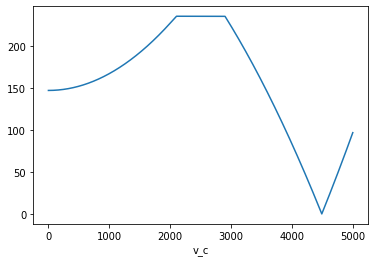

In [27]:
%reload_ext autoreload
%autoreload 2
%run startup.py

idx = 112586



def a(x, v_0, v_1):
    def f(v_c):
        x_a, t_a = accel_xt(v_0, v_c, a_max)
        x_d, t_d = accel_xt(v_c, v_1, a_max)

        return abs((x_a + x_d) - x)
    
    return f

i, inputs = limits()[idx]
(x, v_0, v_1) = inputs
v_0, v_c, v_1, x_a, t_a, x_d, t_d, flag = _calc_vc_min(x, v_0, v_1, v_max, a_max)

print(inputs, v_c, x, x_a+x_d)

g = a(*inputs)
              
df = pd.DataFrame([{'v_c':v_c, 'f':g(v_c)} for v_c in range(0,5000)]).set_index('v_c')

df.f.plot()


In [ ]:
%reload_ext autoreload
%autoreload 2
%run startup.py

a_max = 50_000
v_max = 5_000



def f(x, v_0, v_c, v_1):
    
    v_l, v_h = min(v_0, v_1), max(v_0, v_1)
    
    x_a, t_a = accel_xt(v_0, v_c, a_max)
    x_d, t_d = accel_xt(v_c, v_1, a_max)
    
    if v_l <= v_c <= v_h:
        # For v_0 <= v_c <= v_1 t_a + t_d will be constant. 
        t_ad = abs(v_h-v_l)/a_max
        x_ad = (v_0+v_1)/2*t_ad
        # x_ad = (v_0 - v_1)*(v_0 + v_1)/(2*a_max)
        x_c = x - x_ad
        t_c = x_c/v_c
        
    elif v_c < v_l:
        ...
        
    else: # v_c > v_h
        ...   
    
    
    x_c = x - (x_a + x_d)
    if v_c != 0:
        t_c = x_c/v_c
    else:
        t_c = 0
         
    t = t_a + t_c + t_d
    
    return dict(x=x,t=t, t_a=t_a, x_a=x_a, x_d=x_d, t_d=t_d, v_0=v_0, v_1=v_1, x_c=x_c, v_c=v_c, t_c=t_c)

def a(x, v_0, v_1):
    
    return lambda v_c: f(x, v_0, v_c, v_1)

v_0 = 2500
v_1 = 3500
x = 150

g = a(x, v_0, v_1)

df = pd.DataFrame([g(v_c) for v_c in range(0,5000)]).set_index('v_c')


fig, axes = plt.subplots(1,3, figsize=(18,3))

t_min = df.t.min()

v_c = df.t.idxmin()
#t_v_c = (a_max*t_f + v_0 - v_1)/(2*a_max)

print("v_c for t min", v_c, df.loc[v_c].t.round(3))
#print("Calc v_c", calc_v_c(x, t_min, v_0, v_1, v_max, a_max))

ax = df[df.t < t_min*4].t.plot(ax=axes[0])
ax = (df.t_a+df.t_d).plot(ax=ax)
#ax = (df.t_c).plot(ax=ax)

ax = (df.x_a+df.x_d).plot(ax=axes[1])
ax = (df.x_a+df.x_d).plot(ax=ax)

g(1)['t'], g(v_0)['t'], g(v_1)['t'], g(4500)['t']

In [ ]:
v_0 = 2500
v_1 = 3500
x = 150

rows = []
for v_c in range(0,5000):
    v_c = calc_v_c(x, t, v_0, v_1, v_max, a_max)
    rows.append(
    
    

In [ ]:
t = df[df.recalcs >0]
#df = df.astype(int)
display(t.describe())

#t.plot.scatter(x='v_m_t', y='v_c', marker='.')
sns.scatterplot(data=t, x="v_m", y="v_c", hue="x", legend=False, palette='viridis')

In [ ]:
z = t.groupby('v_c').
z

In [ ]:
df[df.v_c==2657].plot.scatter(x='x', y='v_m', marker='.')

In [ ]:
import seaborn as sns
%matplotlib inline 
sns.scatterplot(data=df.sample(5000), x="v_c", y="v_m", hue="x", legend=False, palette='viridis')

In [ ]:
df.groupby('v_c').x.describe()

In [ ]:
from trajectory.trapmath import calc_v_c as cvc1



    
rows = []
for x, v_0, v_1 in choices(list(product(distances, velocities, velocities)), k=20000):
    
    p = min_profile(x, v_0, v_1, v_max, a_max)
    
    v_c_1 = cvc1(p.x, p.t, p.v_0, v_1, p.v_max, p.a_max)

    v_c_4 = hex_v_c(p.x, p.t, p.v_0, p.v_1, p.v_max, p.a_max)
    
    _, v_c_3, _, _, _, _, _, _ = find_v_c(x, v_0, v_1, v_max, a_max)
    
    
    rows.append(dict(x=x, v_0=v_0, v_1=v_1,  v_c=p.v_c, v_c_1=min(v_c_1), v_c_3=v_c_3, v_c_4=v_c_4))
    
df = pd.DataFrame(rows)
df = df.astype(int)
df['err'] = df.v_c_4 - df.v_c
df.head()

In [ ]:
df['err'] = df.v_c_3 - df.v_c
df.sort_values('err', ascending = False)

In [ ]:
df[df.err.abs() > 1][['v_0','v_1']].sum(axis=1).divide(2).mean()

In [ ]:
df[df.err.abs() > 1].err.hist()